In [1]:
%reset -f
#=============================================================================
##############################################################################
##############################################################################
# IMPORT ALL TIME PACKAGES
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle, time, random, sys, warnings
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'


##############################################################################
# ENCODING FUNCTIONS
##############################################################################

# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER OR NORMALISE CONTINUOUS VARIABLES
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod, df
############################################################
def Normalise_n_encode_train_set(X_data, feat_list, data_types):
    encoder = []
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = X_data[feat]
            mean        = X_data_feat.mean()
            std         = X_data_feat.std()
            X_data_norm_2[feat] = (X_data_feat - mean)/std
            encoder.append([feat, data_types[feat], [mean, std]])
        elif data_types[feat] == 'Categorical':
            X_data_norm_2[feat],df = target_encoder_Binary(feat, 'Mortality', X_data)
            encoder.append([feat, data_types[feat], df])
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = X_data[feat].copy()
            encoder.append([feat, data_types[feat], ""])
    encoder =pd.DataFrame(encoder, columns = ['feature','type','parameters'])
    return X_data_norm_2,encoder
############################################################
def Normalise_n_encode_val_set(val_data, norm_encoder, feat_list, data_types):
    X_data_norm_2 = pd.DataFrame()
    for feat in feat_list:
        if data_types[feat] == 'Continuous':
            X_data_feat = val_data[feat]
            mean, std   = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = (X_data_feat - mean)/std

        elif data_types[feat] == 'Categorical':
            df = norm_encoder[norm_encoder['feature'] == feat].iloc[0]['parameters']
            X_data_norm_2[feat] = val_data[feat].map(dict(zip(df.index, df['prob'])))
            X_data_norm_2[feat] = X_data_norm_2[feat].fillna(0)
        elif data_types[feat] == 'Binary':
            X_data_norm_2[feat] = val_data[feat].copy()
    return X_data_norm_2
##############################################################################
# PLOTTING FUNCTIONS 
##############################################################################
def history_plots_(history, SAVE = 0, name = ''):
    auc_keys = [x for x in history.history.keys() if 'auc' in x]
    loss = history.history["loss"];     val_loss = history.history["val_loss"]
    acc  = history.history["accuracy"]; val_acc  = history.history["val_accuracy"]
    auc  = history.history[auc_keys[0]];      val_auc = history.history[auc_keys[1]]
    epochs  = range(1, len(acc) + 1)
    f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (8,4))
    ax0.plot(epochs, loss, "bo", label="Training Loss")
    ax0.plot(epochs, val_loss, "b", label="Validation Loss")
    ax0.set_title("Train-val Loss")
    ax1.plot(epochs, acc, "bo", label="Training Accuracy")
    ax1.plot(epochs, val_acc, "b", label="Validation Accuracy")
    ax1.set_title("Train-val Accuracy")
    ax2.plot(epochs, auc, "bo", label="Training AUC")
    ax2.plot(epochs, val_auc, "b", label="Validation AUC")
    ax2.set_title("Train-val AUC")
    plt.legend()
    if SAVE == 1: plt.savefig(name, transparent = True, bbox_inches = "tight")
    plt.show()
# ============================================================================


2023-07-25 11:08:33.977454: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2023-07-25 11:08:33.977484: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
t_tot = time.time()
# ##############
# 1. LOAD DATA ---------------------------------------------------------------
# ============================================================================
t = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'
df_patients_16_18, df_admissions_16_18, df_eobs_16_18 = load_fn.Load_data()
df_patients_19_20, df_admissions_19_20, df_eobs_19_20 = load_fn.Load_data('2019_2020')

X_data_16_18 = pickle.load(open(path + 'df_ts_2016_18.pickle','rb')).drop(columns = 'no_sample_series')
X_data_19_20 = pickle.load(open(path + 'df_ts_2019_20.pickle','rb')).drop(columns = 'no_sample_series')


# Dictionary of features and types --------
data_types = pd.read_csv('/home/d/dlr10/Documents/02_Statitics_modelling/2_Statistics/csv_Type_variables.csv')
data_types = data_types.set_index('Variable').to_dict()['Type']

# List of features ------------------------
feat_list = X_data_16_18.columns.tolist()
feat_list = feat_list[1:-1]

# Resulst vaiables ------------------------
df_results_train = pd.DataFrame()
df_results_valid = pd.DataFrame()
dict_fpr_tpr = {}

print("Elapsed time loading data:", time.time()-t)
# ============================================================================

Elapsed time loading data: 43.22415852546692


In [3]:
display(X_data_16_18.head(5))

admission_id         rr  ews heart_rate temperature         sbp        dbp  \
0     78793793  20.000000  2.0       98.0        37.4       101.0       40.0   
1     78793793  19.714285  1.0  95.428571   37.514286  109.285714  55.714286   
2     78793793  19.428572  1.0  92.857143   37.628571  117.571429  71.428571   
3     78793793  19.142857  0.0  90.285714   37.742857  125.857143  87.142857   
4     78793793  19.200001  0.0       92.8       37.58       131.6       87.2   

  Oxygen_Saturation Assisted_O2  Confusion   CREA  UREA    K   GFR    WBC  \
0              97.0         1.0        1.0  129.0  10.8  5.1  48.5  8.725   
1         97.571429         1.0        1.0  129.0  10.8  5.1  48.5  8.725   
2         98.142857         1.0        1.0  129.0  10.8  5.1  48.5  8.725   
3         98.714286         1.0        1.0  129.0  10.8  5.1  48.5  8.725   
4              98.0         1.0        1.0  129.0  10.8  5.1  48.5  8.725   

      PLT      HCT     HGB    RBC   MCH    MCV   NEUAB TLYMAB EOSAB MONAB  \
0  299.75  0.31525  104.25  3.345  31.2  94.25  7.5175   0.71  0.17   0.3   
1  299.75  0.31525  104.25  3.345  31.2  94.25  7.5175   0.71  0.17   0.3   
2  299.75  0.31525  104.25  3.345  31.2  94.25  7.5175   0.71  0.17   0.3   
3  299.75  0.31525  104.25  3.345  31.2  94.25  7.5175   0.71  0.17   0.3   
4  299.75  0.31525  104.25  3.345  31.2  94.25  7.5175   0.71  0.17   0.3   

   BASAB   ALB    ALP BILI  sex  ethnicity  age_at_admin  Comorb_score  \
0  0.015  31.0  103.0  6.0 -1.0        0.0          88.0           2.0   
1  0.015  31.0  103.0  6.0 -1.0        0.0          88.0           2.0   
2  0.015  31.0  103.0  6.0 -1.0        0.0          88.0           2.0   
3  0.015  31.0  103.0  6.0 -1.0        0.0          88.0           2.0   
4  0.015  31.0  103.0  6.0 -1.0        0.0          88.0           2.0   

   Spcfc_Comorb  Mortality  
0           0.0        1.0  
1           0.0        1.0  
2           0.0        1.0  
3           0.0        1.0  
4           0.0        1.0

# Divide admission by outcome

In [4]:
admins_0 = X_data_16_18[X_data_16_18['Mortality'] == 0]['admission_id'].unique().tolist()
admins_1 = X_data_16_18[X_data_16_18['Mortality'] == 1]['admission_id'].unique().tolist()

print('Mortal admissions', len(admins_1))
print('Discharged admissions', len(admins_0))

# Select time-series of specific feature

Mortal admissions 2024
Discharged admissions 7366


### Sampling Feature TS

In [5]:
feature   = 'heart_rate'

samp_adm_0 = random.sample(admins_0, 1000) 
samp_adm_1 = random.sample(admins_1, 1000)
lst_admns  = samp_adm_0 + samp_adm_1

df        = X_data_16_18[X_data_16_18['admission_id'].isin(lst_admns)]
feat_tss  = df[feature]
#lst_admns = df['admission_id'].unique().tolist()

mort_df   = df[['admission_id', 'Mortality']].groupby(by = ['admission_id']).mean()
mort_dict = dict(zip(mort_df.index, mort_df['Mortality']))
lst_mort  = [mort_dict[i] for i in lst_admns]

# Array with the ts of each admission of the defined feature
X_feat_ts = np.array(feat_tss).reshape((len(lst_admns), int(len(df) / len(lst_admns))))
display(X_feat_ts.shape)

(2000, 144)

In [6]:
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [7]:
mySeries = []
for i in range(X_feat_ts.shape[0]):
    scaler = MinMaxScaler()
    mySeries.append((MinMaxScaler().fit_transform(X_feat_ts[i,:].reshape(-1,1)).T).tolist()[0])
mySeries_pd = pd.DataFrame(mySeries)

In [8]:
mySeries_pd.head()

0         1         2         3         4         5         6    \
0  0.518519  0.759259  1.000000  0.995885  0.991770  0.987654  0.983539   
1  0.117647  0.253119  0.388592  0.524064  0.659537  0.795009  0.690196   
2  1.000000  0.976852  0.953704  0.930556  0.907407  0.884259  0.861111   
3  0.555098  0.703399  0.851699  1.000000  0.966014  0.749743  0.533471   
4  0.365854  0.182927  0.000000  0.117073  0.234146  0.359756  0.493902   

        7         8         9         10        11        12        13   \
0  0.979424  0.975309  0.971193  0.967078  0.962963  0.888889  0.814815   
1  0.345098  0.000000  0.068627  0.137255  0.145658  0.154062  0.162465   
2  0.837963  0.814815  0.611111  0.407407  0.203704  0.000000  0.069136   
3  0.439753  0.468589  0.497425  0.498326  0.471292  0.444258  0.417225   
4  0.469512  0.286585  0.298780  0.506098  0.600000  0.580488  0.560976   

        14        15        16        17        18        19        20   \
0  0.740741  0.666667  0.592593  0.518519  0.444444  0.370370  0.317460   
1  0.170868  0.179272  0.187675  0.196078  0.200980  0.205882  0.210784   
2  0.138272  0.207407  0.276543  0.345679  0.414815  0.483951  0.523148   
3  0.390191  0.363157  0.336123  0.309089  0.294027  0.290937  0.287848   
4  0.541463  0.521951  0.502439  0.482927  0.463415  0.443902  0.424390   

        21        22        23        24        25        26        27   \
0  0.264550  0.211640  0.158730  0.105820  0.052910  0.000000  0.087963   
1  0.215686  0.220588  0.225490  0.230392  0.235294  0.247549  0.259804   
2  0.532407  0.541667  0.550926  0.560185  0.569444  0.578704  0.587963   
3  0.284758  0.281668  0.278579  0.275489  0.272400  0.269310  0.266220   
4  0.443598  0.501524  0.559451  0.617378  0.675305  0.733232  0.791159   

        28        29        30        31        32        33        34   \
0  0.175926  0.263889  0.351852  0.439815  0.527778  0.615741  0.703704   
1  0.272059  0.284314  0.296569  0.308824  0.321078  0.333333  0.316993   
2  0.580247  0.555556  0.574074  0.592593  0.611111  0.629630  0.640000   
3  0.263131  0.260041  0.256952  0.253862  0.270216  0.306012  0.341809   
4  0.849085  0.829268  0.731707  0.634146  0.660754  0.687361  0.713969   

        35        36        37        38        39        40        41   \
0  0.671296  0.638889  0.606481  0.574074  0.541667  0.509259  0.476852   
1  0.300654  0.284314  0.267974  0.251634  0.235294  0.235294  0.235294   
2  0.650370  0.660741  0.671111  0.681481  0.691852  0.702222  0.712593   
3  0.377606  0.413402  0.449199  0.484996  0.520793  0.556589  0.592386   
4  0.740576  0.767184  0.763720  0.730183  0.696646  0.663110  0.629573   

        42        43        44        45        46        47        48   \
0  0.444444  0.427609  0.410774  0.393939  0.377104  0.360269  0.343434   
1  0.235294  0.235294  0.235294  0.235294  0.235294  0.235294  0.235294   
2  0.722963  0.733333  0.743704  0.754074  0.756410  0.750712  0.745014   
3  0.628183  0.663980  0.699776  0.735573  0.771370  0.745417  0.719464   
4  0.596037  0.562500  0.528963  0.522866  0.544207  0.565549  0.586890   

        49        50        51        52        53        54        55   \
0  0.326599  0.309764  0.292929  0.276094  0.259259  0.340067  0.420875   
1  0.235294  0.235294  0.235294  0.235294  0.235294  0.235294  0.235294   
2  0.739316  0.733618  0.727920  0.722222  0.716049  0.709877  0.703704   
3  0.693512  0.667559  0.641607  0.615654  0.589701  0.563749  0.537796   
4  0.608232  0.629573  0.650915  0.672256  0.684362  0.687231  0.690100   

        56        57        58        59        60        61        62   \
0  0.501684  0.582492  0.663300  0.703704  0.703704  0.699074  0.694444   
1  0.235294  0.235294  0.232026  0.225490  0.218954  0.212418  0.205882   
2  0.697531  0.691358  0.685185  0.679012  0.672840  0.666667  0.661793   
3  0.511843  0.484318  0.456792  0.429267  0.401741  0.374216  0.346690   
4  0.692970  0.695839  0.

# SOM Self Organised Map

In [53]:
import math
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
som_x = som_y = 6
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som
t = time.time()
som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.01)
#som = MiniSom(8, 8,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 500000)
print("elapsed", time.time()-t)

elapsed 59.43804907798767


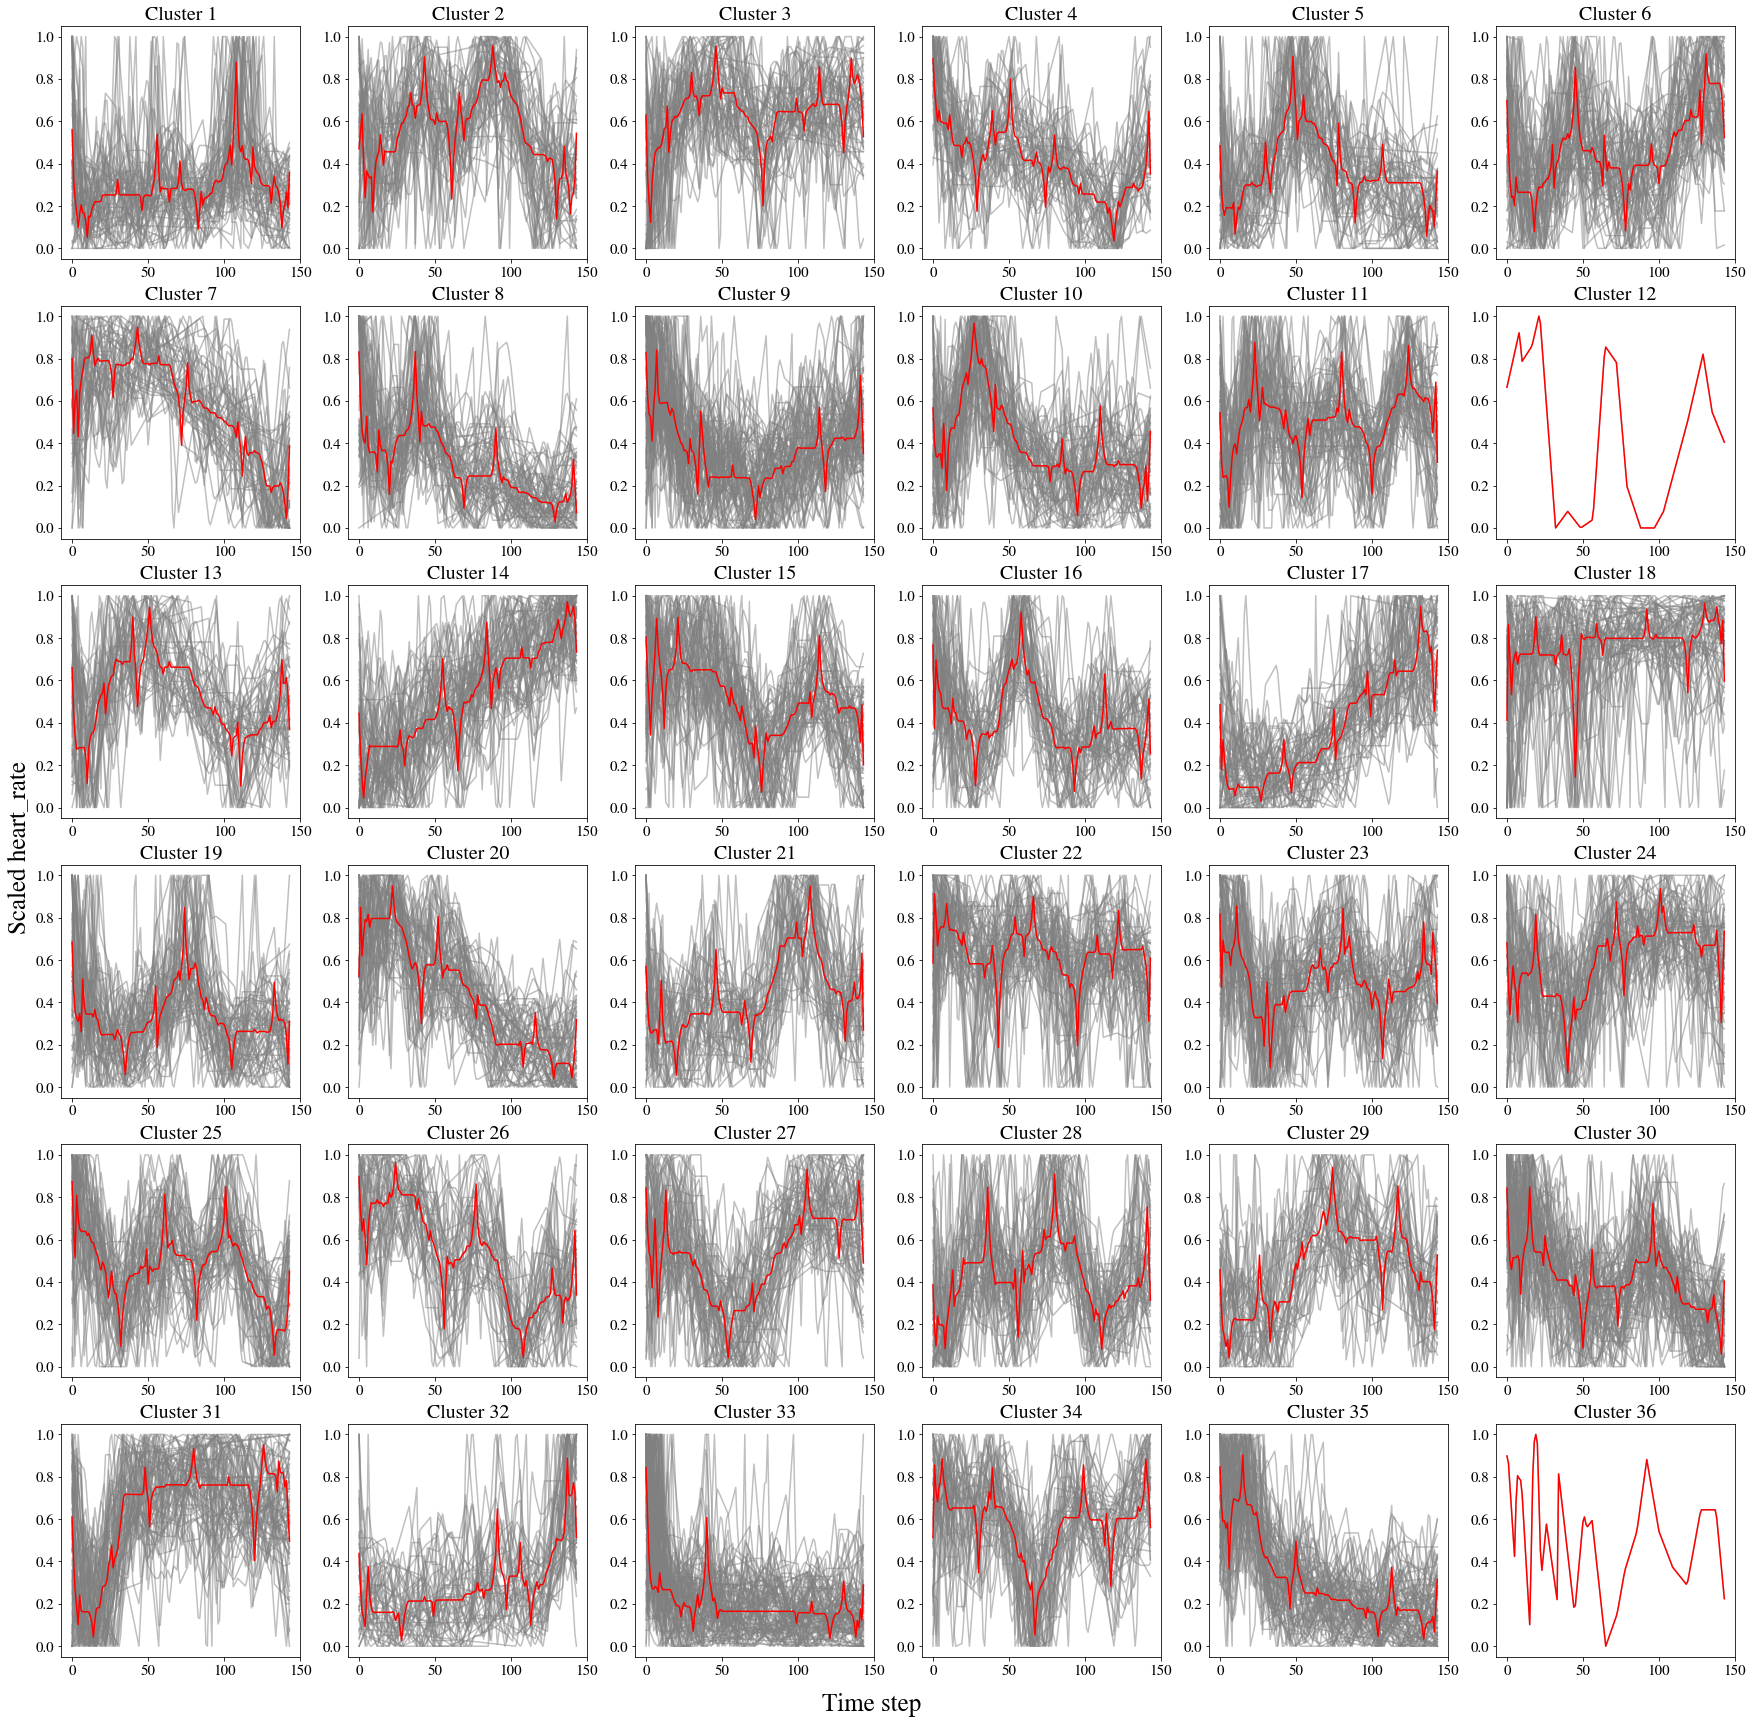

SOM plot time elapsed 26.368104934692383


In [54]:
def plot_som_series_dba_center(som_x, som_y, win_map, feature):
    fig, axs = plt.subplots(som_x,som_y,figsize=(30,30))
    #fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}", fontsize = 20)
            axs[cluster].tick_params(axis='both', labelsize=15)

    fig.text(0.5, 0.1, 'Time step', ha='center', fontsize = 25)
    fig.text(0.1, 0.5, 'Scaled ' + feature, va='center', rotation='vertical', fontsize = 25)
    plt.show()
win_map = som.win_map(mySeries)
t = time.time()
plot_som_series_dba_center(som_x, som_y, win_map, feature)
print("SOM plot time elapsed", time.time()-t)

In [55]:
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            for series in win_map[cluster]:
                a=0
                #print(series)
                break
        break
    break


In [56]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in mySeries]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (som_x,som_y))
cluster_index

array([22, 20,  2, ...,  1,  6, 27])

In [57]:
df_results = []
for idx,adm in enumerate(lst_admns):
    row = [adm, mort_dict[adm], cluster_index[idx]]
    df_results.append(row)
df_results = pd.DataFrame(df_results , columns=['admission_id', 'mortality', 'clusterSOM'])


In [58]:
df_results.head()

admission_id  mortality  clusterSOM
0      86478917        0.0          22
1      86847145        0.0          20
2      93714473        0.0           2
3      98048506        0.0           7
4      26762953        0.0           2

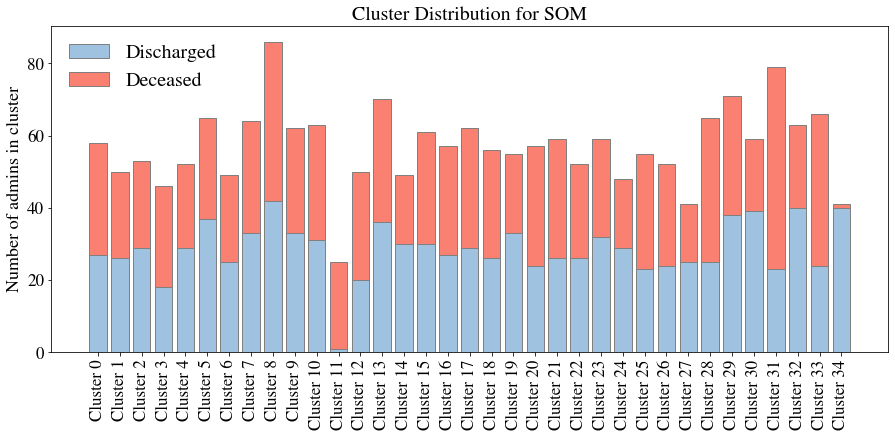

In [60]:
df_ = df_results.groupby(by = ['mortality','clusterSOM']).count()
df_ = df_.sort_values(by = ['mortality','clusterSOM'])
#df_.index
y0 = df_[df_.index.get_level_values(0) == 0]['admission_id'].values
y1 = df_[df_.index.get_level_values(0) == 1]['admission_id'].values


plt.figure(figsize=(15,6))
plt.title("Cluster Distribution for SOM", fontsize  = 20)
plt.bar(range(len(y0)),y0, label = 'Discharged', color ='#9fc2e0', edgecolor='gray')
plt.bar(range(len(y0)),y1, label = 'Deceased', color =  '#FA8072', edgecolor='gray', bottom = y0)

plt.xticks(range(len(y0)), ["Cluster {price:.0f}".format(price = x) for x in range(len(y0))], rotation =90)
plt.ylabel('Number of admins in cluster', fontsize = 18)
plt.tick_params(axis='both', labelsize=17)
plt.legend(fontsize = 20, frameon=False)

plt.show()

# K-Means

In [15]:
from tslearn.generators import random_walks
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape, TimeSeriesKMeans

In [16]:
n_clust = 36
X_bis = to_time_series_dataset(mySeries)
print(type(X_bis))
X_bis.shape

<class 'numpy.ndarray'>


(2000, 144, 1)

In [17]:
t = time.time()
km = TimeSeriesKMeans(n_clusters=n_clust, max_iter=5000,# verbose = True,
                      metric="dtw", random_state=0)
y_pred = km.fit_predict(X_bis)
print("elapsed", time.time()-t)

elapsed 527.0334756374359


In [71]:
df_results

admission_id  mortality  clusterSOM
0         86478917        0.0          22
1         86847145        0.0          20
2         93714473        0.0           2
3         98048506        0.0           7
4         26762953        0.0           2
...            ...        ...         ...
1995      65086227        1.0          21
1996      20873041        1.0          22
1997      95290950        1.0           1
1998      16023778        1.0           6
1999       2639638        1.0          27

[2000 rows x 3 columns]

In [70]:
len(y_pred)

2000

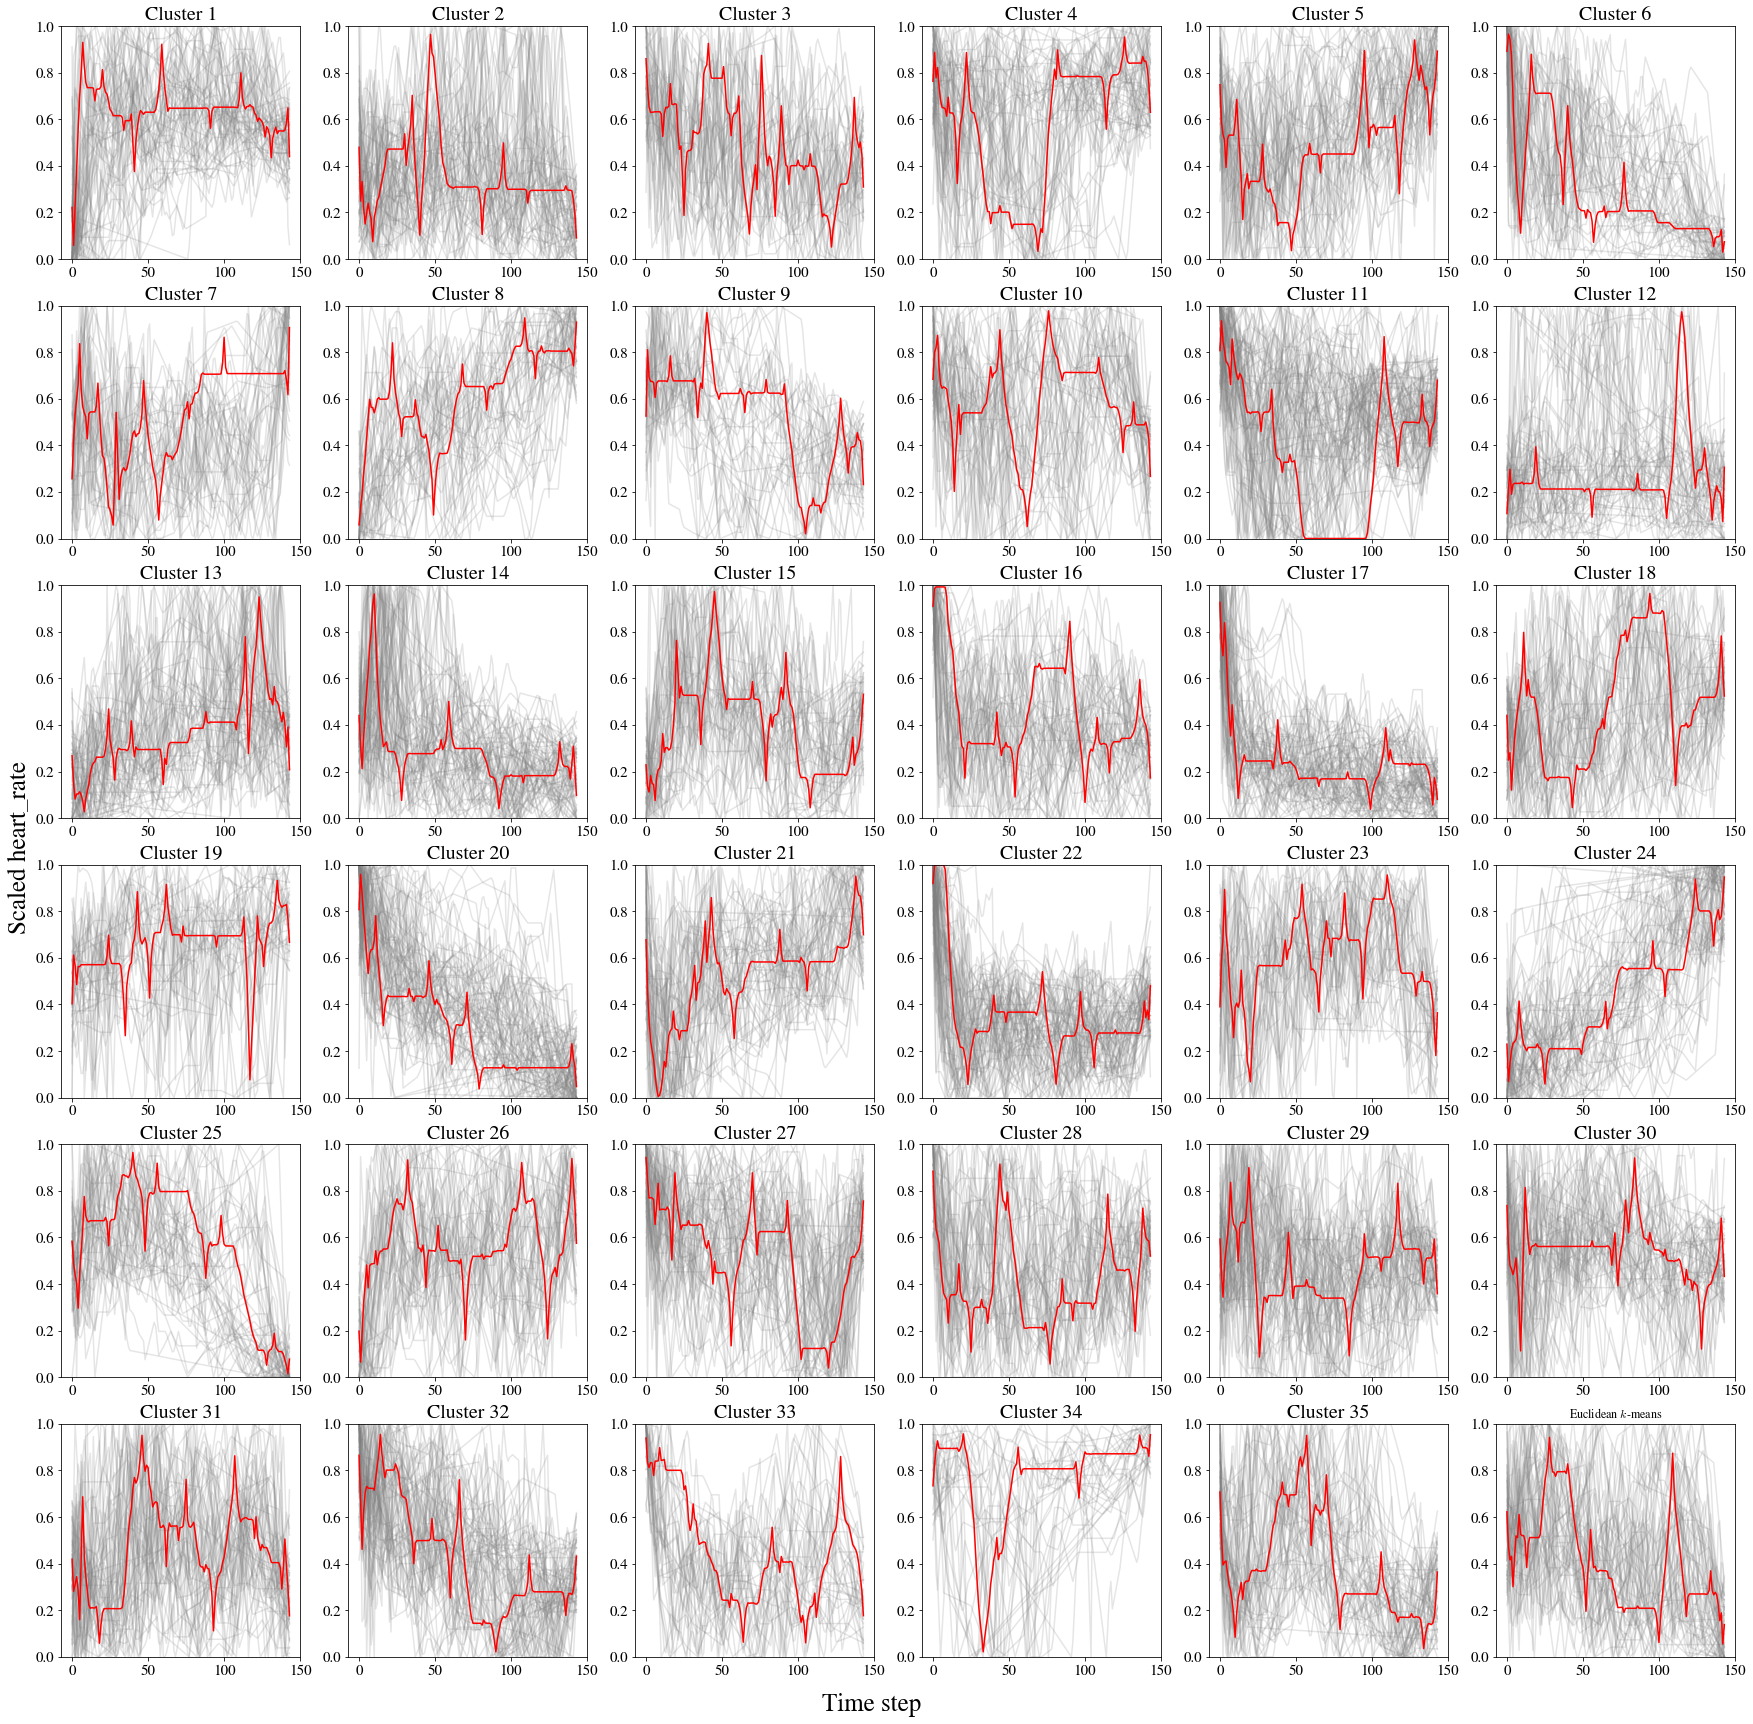

In [68]:
sz = X_bis.shape[1]
fig = plt.figure(figsize=(30,30))
for yi in range(n_clust):
    plt.subplot(6, 6, yi + 1)
    
    for xx in X_bis[y_pred == yi]:
        plt.plot(xx.ravel(), "gray", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.title('Cluster %d' % (yi + 1), fontsize = 20)
    #plt.xlim(0, sz)
    plt.ylim(0, 1)
    plt.tick_params(axis='both', labelsize=15)
fig.text(0.5, 0.1, 'Time step', ha='center', fontsize = 25)
fig.text(0.1, 0.5, 'Scaled ' + feature, va='center', rotation='vertical', fontsize = 25)
plt.tick_params(axis='both', labelsize=15)
plt.title("Euclidean $k$-means")
plt.show()

# K Shape

In [19]:
t = time.time()
ks = KShape(n_clusters=n_clust, n_init=1, random_state=0)

y_pred_ks = ks.fit_predict(X_bis)
print("elapsed", time.time()-t)

elapsed 122.64834213256836


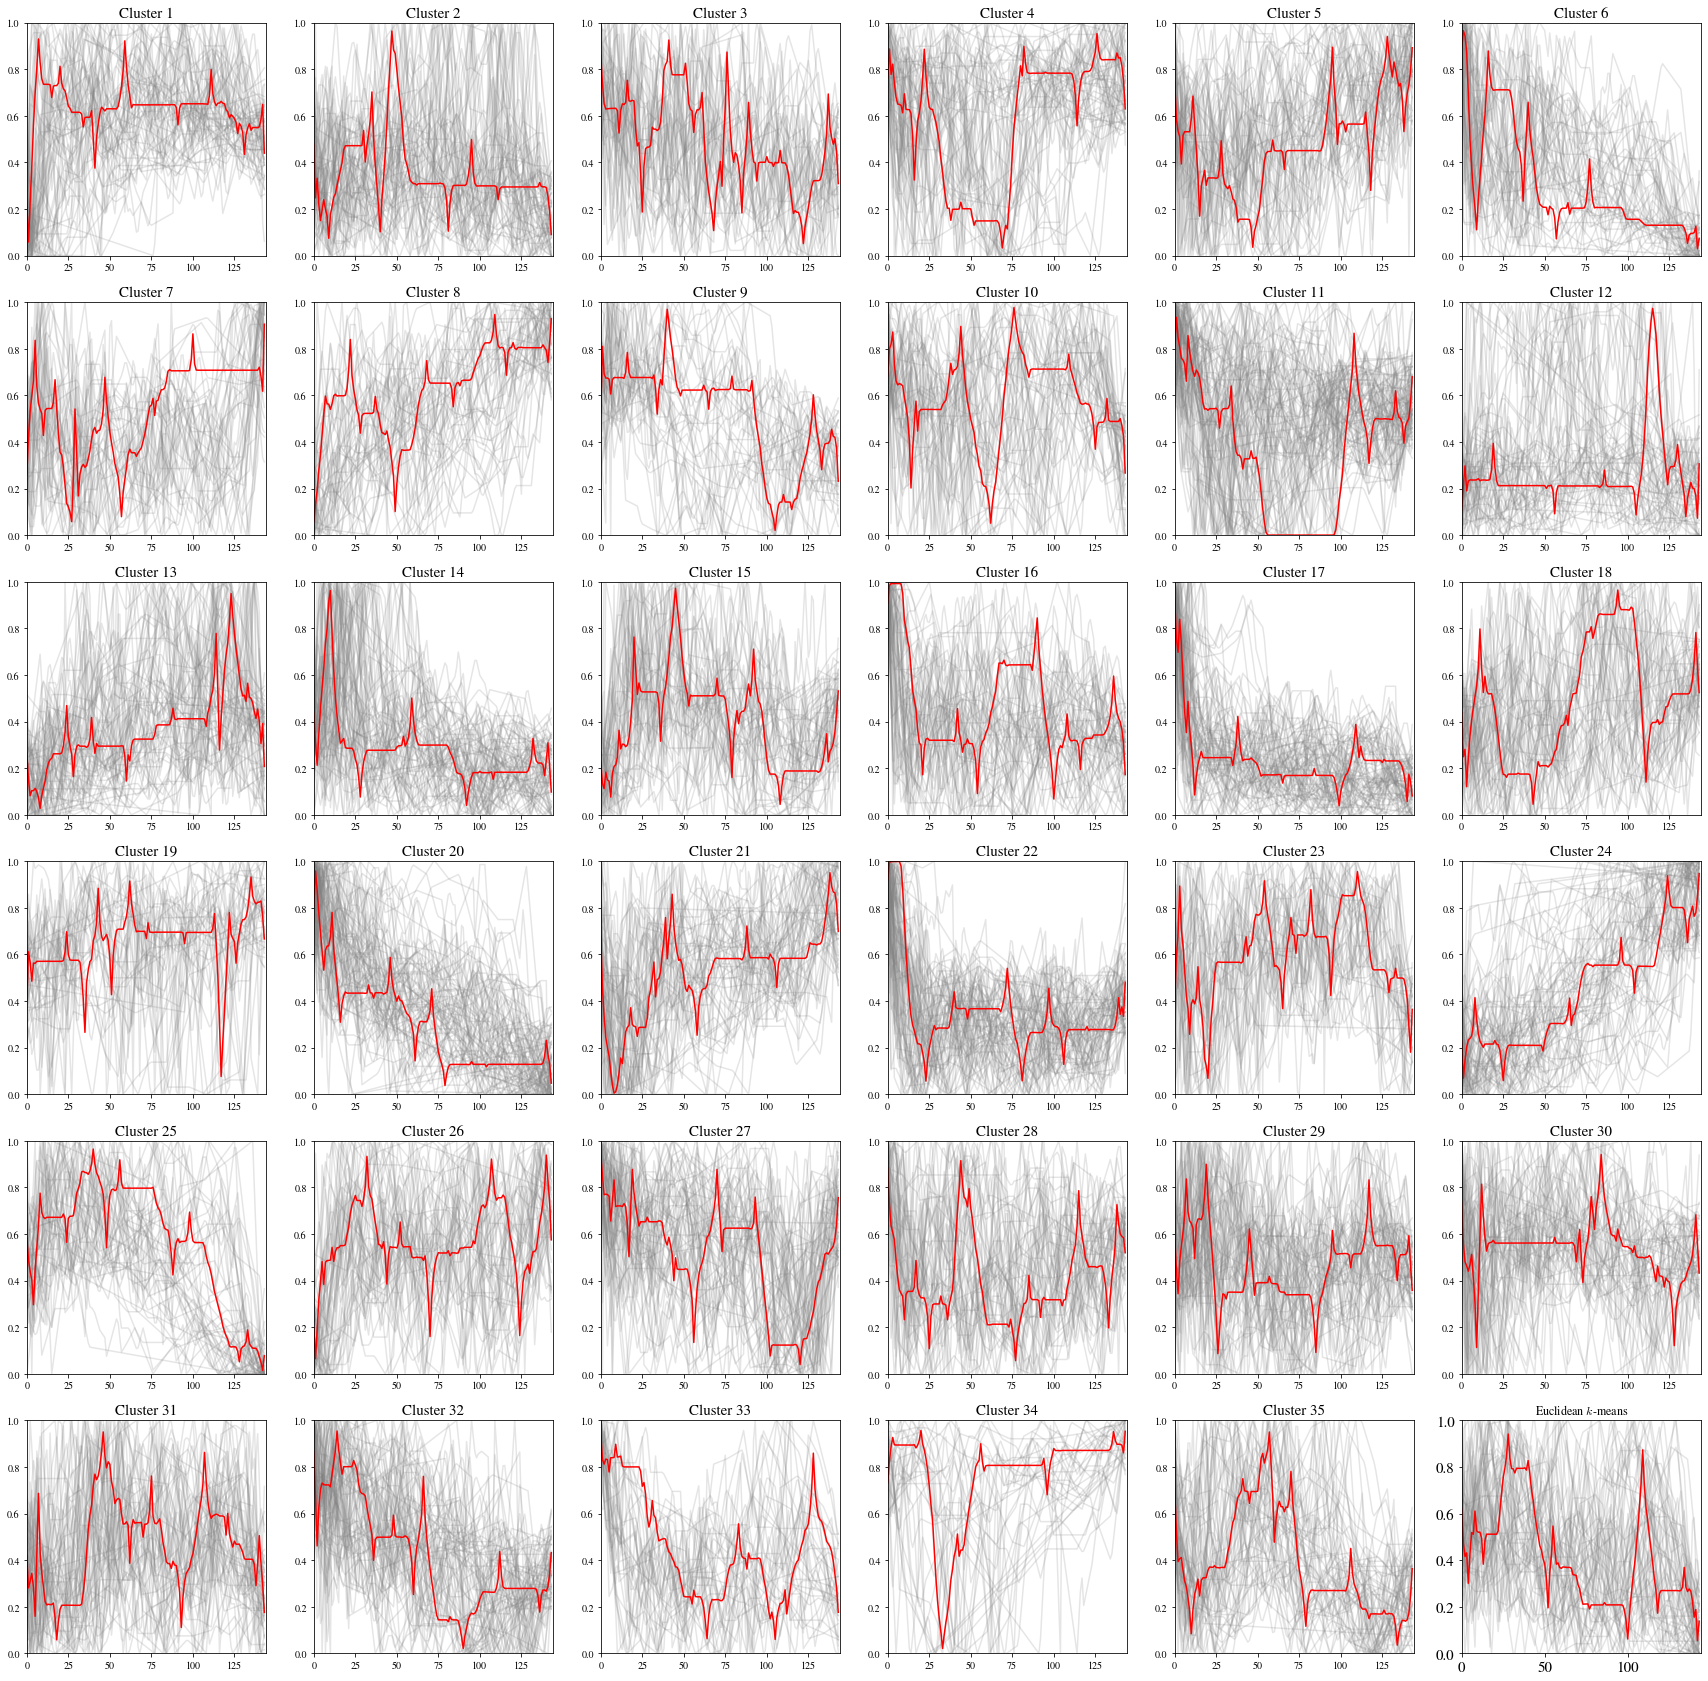

In [21]:
sz = X_bis.shape[1]
plt.figure(figsize=(30,30))
for yi in range(n_clust):
    plt.subplot(6, 6, yi + 1)    
    for xx in X_bis[y_pred == yi]:
        plt.plot(xx.ravel(), "gray", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.title('Cluster %d' % (yi + 1), fontsize = 15)
    plt.xlim(0, sz)
    plt.ylim(0, 1)
    #plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
#    if yi == 1:
plt.tick_params(axis='both', labelsize=15)
plt.title("Euclidean $k$-means")
plt.show()

In [ ]:
sz = X_bis.shape[1]
plt.figure(figsize=(25,25))
for yi in range(n_clust):
    plt.subplot(6, 6, yi + 1)
    
    for xx in X_bis[y_pred_ks == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBSCAN

In [ ]:

from sklearn.cluster import DBSCAN
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def dbscansim(ts1, ts2):
    distance, _ = fastdtw(ts1, ts2, dist=euclidean)
    return distance

t = time.time()
clustering = DBSCAN(eps=100, min_samples=2, metric = dbscansim).fit(X_bis.reshape(X_bis.shape[0], X_bis.shape[1]))
print("elapsed", time.time()-t)

In [ ]:
labels = clustering.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

#def plot_series_dbscan(som_x, som_y, n_clusters_, labels_):
labels_ = labels
fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
fig.suptitle('Clusters')
for x in range(som_x):
    for y in range(som_y):
        cluster_pos = (x,y)
        for cluster in range(n_clusters_):
            series_cluster = X_bis[labels_== cluster]
            for series in series_cluster:
                axs[cluster_pos].plot(series.ravel(), "k-", alpha=.2)

            axs[cluster_pos].plot(dtw_barycenter_averaging(np.vstack(series_cluster)),c="red") # I changed this part
        cluster_number = x*som_y+y+1
        axs[cluster_pos].set_title(f"Cluster {cluster_number}")
plt.show()

## Divide into windows

time_window_size = 36 # timesteps
time_overlap     = 12 # timesteps

time_step = (time_window_size - time_overlap)

ls_ts_seg = []
idx_ts_sg = []
for i in range(X_feat_ts.shape[1] // time_step):
    lo_bd = i *time_step
    up_bd = lo_bd +  time_window_size if lo_bd +  time_window_size <=  X_feat_ts.shape[1] else  X_feat_ts.shape[1] 
    print(i,  lo_bd, up_bd)
    idx_ts_sg.append([lo_bd, up_bd])
    ls_ts_seg.append(X_feat_ts[:,lo_bd: up_bd])

## Dynamic Time Wrapping

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

x = np.array([1, 2, 3, 3, 7])
y = np.array([1, 2, 2, 2, 2, 2, 2, 4])

distance, path = fastdtw(x, y, dist=euclidean)
distance

## Computing the similarity (correlation) matrix


t = time.time()
dim = len(ls_ts_seg) * X_feat_ts.shape[0]
corr_matrix = np.zeros((dim, dim))

for window in  range(len(ls_ts_seg)):
    ls_seg = ls_ts_seg[window]
    for idx, ts1 in enumerate(ls_seg):
        for window_2 in  range(len(ls_ts_seg)):
            ls_seg_2 = ls_ts_seg[window_2]
            for idx_2, ts2 in enumerate(ls_seg_2):
                distance, _ = fastdtw(ts1, ts2, dist=euclidean)
                
                i = (window * len(ls_seg)) + idx
                j = (window_2 * len(ls_seg_2)) + idx_2
                
                corr_matrix[i][j] = distance
                #print(i,j, distance)
                break
            break
        break
    break
print("time elapsed:", time.time() - t)

## clustering DBSCAN

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1, min_samples=2).fit(corr_matrix)
clustering.labels_.sum()
#array([ 0,  0,  0,  1,  1, -1])
